# 模型推理 - 使用 QLoRA 微调后的 ChatGLM3-6B

In [2]:
import torch
from transformers import AutoModel, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel, PeftConfig

# 定义全局变量和参数
# model_name_or_path = 'THUDM/chatglm3-6b'  # 模型ID或本地路径
out_model_path = 'chatglm3-6b_QLoRA/'
peft_model_path = f"models/{out_model_path}"


In [3]:
config = PeftConfig.from_pretrained(peft_model_path)

q_config = BitsAndBytesConfig(load_in_4bit=True,
                              bnb_4bit_quant_type='nf4',
                              bnb_4bit_use_double_quant=True,
                              bnb_4bit_compute_dtype=torch.float32)

base_model = AutoModel.from_pretrained(config.base_model_name_or_path,
                                       quantization_config=q_config,
                                       trust_remote_code=True,
                                       device_map='auto')
base_model.requires_grad_(False)
base_model.eval()

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

ChatGLMForConditionalGeneration(
  (transformer): ChatGLMModel(
    (embedding): Embedding(
      (word_embeddings): Embedding(65024, 4096)
    )
    (rotary_pos_emb): RotaryEmbedding()
    (encoder): GLMTransformer(
      (layers): ModuleList(
        (0-27): 28 x GLMBlock(
          (input_layernorm): RMSNorm()
          (self_attention): SelfAttention(
            (query_key_value): Linear4bit(in_features=4096, out_features=4608, bias=True)
            (core_attention): CoreAttention(
              (attention_dropout): Dropout(p=0.0, inplace=False)
            )
            (dense): Linear4bit(in_features=4096, out_features=4096, bias=False)
          )
          (post_attention_layernorm): RMSNorm()
          (mlp): MLP(
            (dense_h_to_4h): Linear4bit(in_features=4096, out_features=27392, bias=False)
            (dense_4h_to_h): Linear4bit(in_features=13696, out_features=4096, bias=False)
          )
        )
      )
      (final_layernorm): RMSNorm()
    )
    (output_la

## 微调前后效果对比

### ChatGLM-6B

```
输入：

类型#裙*版型#显瘦*风格#文艺*风格#简约*图案#印花*图案#撞色*裙下摆#压褶*裙长#连衣裙*裙领型#圆领

ChatGLM-6B 微调前输出：

* 版型：修身
* 显瘦：True
* 风格：文艺
* 简约：True
* 图案：印花
* 撞色：True
* 裙下摆：直筒或微喇
* 裙长：中长裙
* 连衣裙：True

ChatGLM-6B 微调后输出：

一款简约而不简单的连衣裙，采用撞色的印花点缀，打造文艺气息，简约的圆领，修饰脸型。衣袖和裙摆的压褶，增添设计感，修身的版型，勾勒出窈窕的身材曲线。
```

### ChatGLM2-6B

```
输入：
类型#裙*版型#显瘦*风格#文艺*风格#简约*图案#印花*图案#撞色*裙下摆#压褶*裙长#连衣裙*裙领型#圆领

微调前：
这款裙子,版型显瘦,采用简约文艺风格,图案为印花和撞色设计,裙下摆为压褶裙摆,裙长为连衣裙,适合各种场合穿着,让你舒适自在。圆领设计,优雅清新,让你在任何场合都充满自信。如果你正在寻找一款舒适、时尚、优雅的裙子,不妨 考虑这款吧!

微调后: 
这款连衣裙简约的设计，撞色印花点缀，丰富了视觉，上身更显时尚。修身的版型，贴合身形，穿着舒适不束缚。圆领的设计，露出精致锁骨，尽显女性优雅气质。下摆压褶的设计，增添立体感，行走间更显飘逸。前短后长的设计，显 得身材比例更加完美。文艺的碎花设计，更显精致。
```

### ChatGLM3-6B

In [4]:
input_text = '类型#裙*版型#显瘦*风格#文艺*风格#简约*图案#印花*图案#撞色*裙下摆#压褶*裙长#连衣裙*裙领型#圆领'
print(f'输入：\n{input_text}')
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path, trust_remote_code=True)

Setting eos_token is not supported, use the default one.
Setting pad_token is not supported, use the default one.
Setting unk_token is not supported, use the default one.


输入：
类型#裙*版型#显瘦*风格#文艺*风格#简约*图案#印花*图案#撞色*裙下摆#压褶*裙长#连衣裙*裙领型#圆领


### 使用0.4个epoch(~40k条样本数据)微调前后对比

In [5]:
response, history = base_model.chat(tokenizer=tokenizer, query=input_text)
print(f'ChatGLM3-6B 微调前：\n{response}')

/data/zlhu/miniconda3/envs/peft/lib/python3.10/site-packages/bitsandbytes/nn/modules.py:226: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(f'Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.')


ChatGLM3-6B 微调前：
这款连衣裙以其文艺风格和简约设计吸引了我的注意。它采用了印花图案和撞色设计，让整个裙子显得非常有活力。压褶的裙下摆增加了裙子的层次感和飘逸感，而裙长则恰如其分地展现了女性的优雅。圆领的设计使得连衣裙的领口更加精致，展现出一种高贵优雅的气质。

这款连衣裙的版型设计非常显瘦，无论是穿着在身上还是站在那里，都能展现出女性身材的优美曲线。它不仅适合各种场合，还能搭配出各种不同的风格。无论是去上班还是约会，这款连衣裙都能为你增添自信和美丽。

总的来说，这款连衣裙不仅具有文艺和简约的风格，还采用了印花图案和撞色设计，增加了整体的时尚感。而压褶的裙下摆和圆领的设计则提升了裙子的品质感，使得整款连衣裙更加优雅精致。无论是从哪个角度看，这款连衣裙都能展现出女性的高贵优雅的气质。


In [6]:
model = PeftModel.from_pretrained(base_model, peft_model_path)
response, history = model.chat(tokenizer=tokenizer, query=input_text)
print(f'ChatGLM3-6B 微调后: \n{response}')

ChatGLM3-6B 微调后: 
连衣裙是很多女性日常出门搭配的单品，简约而时尚的圆领设计，修饰出迷人的脖颈曲线，轻松凸显出优雅的气质。撞色的印花图案，丰富了整体的视觉效果，尽显文艺气质。简约而时尚的压褶裙摆，轻松展现出女性曼妙的身材曲线，尽显柔美气质。修身而合体的版型，上身效果更加出众，尽显女性迷人的身姿。


### 使用0.1个epoch微调前后对比，明显数据量不够导致效果不尽如人意

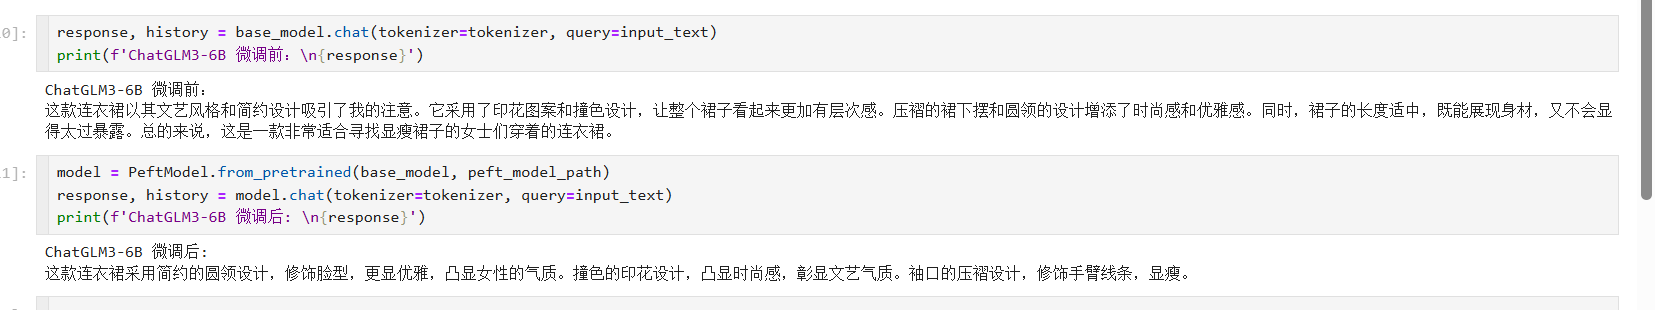